
    Course Project for CMU 02710, 23 Spring.
    
    Author:     Li Chen
    Andrew ID:  lic2
    Email:      lic2@andrew.cmu.edu
    
    Description: 
        The advent of single-cell RNA sequencing (scRNA-seq) has revolutionized our understanding of cellular heterogeneity by enabling the profiling of gene expression at the individual cell level. 
        However, scRNA-seq data are characterized by high-dimensionality, noise, and sparsity, which poses significant challenges for downstream analysis. 
        One key step in the analysis of scRNA-seq data is dimension reduction, which aims to transform the high-dimensional gene expression data into a lower-dimensional representation while preserving the biological variation of interest. 
        To this end, several dimensionality reduction methods have been developed and applied in the analysis of scRNA-seq data.
        In this project, our group picked a dataset and a set of metrics to benchmark different Dimentionality Reduction Methods.
        Furthermore, we strive to make the code easily reproducible, modifiable, and usable for future benchmarking endeavors.

I ran this notebook on Colab with standard GPU + standard RAM.

In [1]:
# You only have to run this cell everytime you connect to a new runtime
from google.colab import drive
drive.mount('/content/drive')

# copy data and lib from Google Drive
! cp -r /content/drive/MyDrive/CMU/23Spring/02710/Project/data /content/data
! cp -r /content/drive/MyDrive/CMU/23Spring/02710/Project/code /content/code

# You can also mannuly set up
# After setup, your Colab Runtime should look like...
"""
  /content
      /drive
      /data
          brain_counts.csv
          brain_metadata.csv
      /code
          AE.py
          Dataset.py
"""

! pip install umap-learn

Mounted at /content/drive


'\n  /content\n      /drive\n      /data\n          brain_counts.csv\n          brain_metadata.csv\n      /code\n          AE.py\n          Dataset.py\n'

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import sys

sys.path.append('/content/code')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Input and Pre-process

In [3]:
# set config
config = {
    "project_absolute_dir": "/content", 
    "counts_filename": "brain_counts.csv",
    "metadata_filename": "brain_metadata.csv"
}

## Metadata info

In [4]:
# read metadata, we kept information in variable "dic_TypeToID" and "dic_NameToID"
metadata_path = os.path.join(config["project_absolute_dir"], "data", config["metadata_filename"])
metadata = pd.read_csv(metadata_path, sep=",", index_col=0) 
type_set = sorted([x.lower() for x in set(metadata['cell_ontology_class'])])
dic_TypeToID = dict(zip(type_set, np.arange(len(type_set))))
metadata['type_id'] = [dic_TypeToID[x.lower()] for x in metadata['cell_ontology_class']]
dic_NameToID = dict(zip(metadata.index, metadata['type_id']))
del metadata, type_set

In [5]:
# translation turns cell type into type id
# type dict turns cell id into type id
print(dic_TypeToID['brain pericyte'])
print(dic_NameToID['D7.MAA000638.3_9_M.1.1'])

2
4


## Counts table

In [6]:
# read matrix
counts_path = os.path.join(config["project_absolute_dir"], "data", config["counts_filename"])
counts = pd.read_csv(counts_path, sep=",", index_col=0) # 3401 cells x 23433 genes
counts.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,0
A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,0,...,0,0,0,0,0,195,0,0,113,0
A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,14,...,0,0,0,0,125,0,1,0,0,0
A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,0,...,0,0,0,81,0,0,0,0,0,0


In [7]:
# intend to find cells with low total gene counts
df = counts[counts.sum(axis=1)>1e5] # drop about ~4% cells

# intend to find genes with low expression level
df = df.T[np.sum(np.array(df) > 5, axis=0) > 3].T   # define detect a gene in a cell: detect more than 5 times
                                                    # if a gene is only detectable in less than three single cells, we drop it

In [8]:
# we use logNorm to normalize data
raw_X = np.array(df) 

CPM_X = raw_X / np.sum(raw_X, axis=1, keepdims=True) * 1e6

logNorm_X = np.log1p(CPM_X / 1e2)

In [9]:
Y = np.array([dic_NameToID[x] for x in df.index])

# Set Network Workflow

## Datast & Dataloader

In [10]:
# PyTorch workflow: 
#   1. we read X from counts table. 
#   2. we did quality control and normalization, get logNorm_X
#   3. logNorm_X --> dataset --> dataloader

from Dataset import Dataset
dataset = Dataset(logNorm_X)

trainloader = torch.utils.data.DataLoader(
    dataset     = dataset, 
    num_workers = 1,
    batch_size  = 32, 
    pin_memory  = True,
    shuffle     = True,
)

# valloader use same dataset, we just don't want to shuffle it
valloader = torch.utils.data.DataLoader(
    dataset     = dataset, 
    num_workers = 1,
    batch_size  = 1, 
    pin_memory  = True,
    shuffle     = False,
)

# sanity check
for x in trainloader:
  print(x.shape)
  break

torch.Size([32, 16730])


## Network

In [11]:
from AE import AE

# x is from the sanity check above
# the second arg is batch_size
model = AE(x.shape[1], 1024).to(DEVICE)

## Pipeline

In [12]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2) # lr and wd are from grid search

from Pipeline import Train, Valid

# VAE Experiment

In [13]:
# train AE here
for epoch in range(30):
  if epoch % 5 == 4:
    optimizer.param_groups[0]['lr'] /= 4
  loss = Train(DEVICE, model, trainloader, criterion, optimizer)
  print(epoch, loss)

0 0.17986282677042717
1 0.14734025409116464
2 0.13982515891685204
3 0.1311724500036707
4 0.1265988780879507
5 0.12520645113260137
6 0.12408222813232272
7 0.12275985577235035
8 0.12140748138521232
9 0.12044297458202231
10 0.12013201868417216
11 0.1197191359950047
12 0.11941810587749761
13 0.11918919095221688
14 0.11900751833237853
15 0.11896715335109655
16 0.11891853407609697
17 0.11887663449434673
18 0.11882610933161249
19 0.11876434438368853
20 0.11874725428574226
21 0.11873546739419301
22 0.11871788650751114
23 0.11870501409558688
24 0.11868726915004206
25 0.11868733145734843
26 0.11867762700307603
27 0.11867707931235724
28 0.11868127705711945
29 0.11867351114165549


In [14]:
# use trained AE to reduce dimension
embedded = Valid(DEVICE, model, valloader)
VAE_X = embedded.cpu().detach().numpy()

VAE, Silhouette:  0.36053336


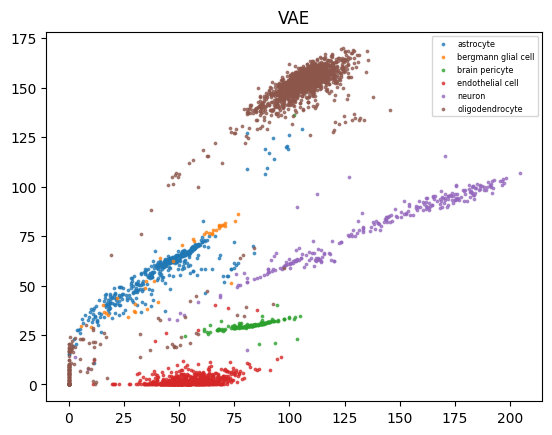

In [15]:
# plot 
fig, ax = plt.subplots()
print("VAE, Silhouette: ", silhouette_score(VAE_X, Y))                    
for i in range(6):
    X1 = VAE_X[Y==i, 0]
    X2 = VAE_X[Y==i, 1]
    ax.scatter(X1, X2, label=list(dic_TypeToID.keys())[i], s=3, alpha=0.7)
ax.legend(loc="best", fontsize='xx-small')
ax.title.set_text('VAE')

# PCA Experiment

logNorm_X, PCA, Silhouette:  0.5294473361906332


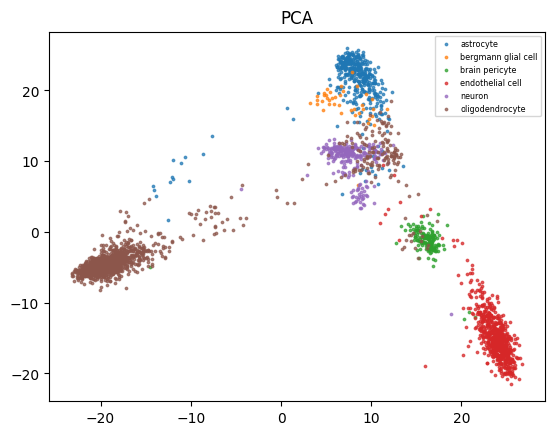

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_X = pca.fit_transform(logNorm_X)

fig, ax = plt.subplots()           
print("logNorm_X, PCA, Silhouette: ", silhouette_score(pca_X, Y))                    
for i in range(6):
    X1 = pca_X[Y==i, 0]
    X2 = pca_X[Y==i, 1]
    ax.scatter(X1, X2, label=list(dic_TypeToID.keys())[i], s=3, alpha=0.7)
ax.legend(loc="best", fontsize='xx-small')
ax.title.set_text('PCA')

# t-SNE Experiment

logNorm_X, t-SNE, Silhouette:  0.5019861


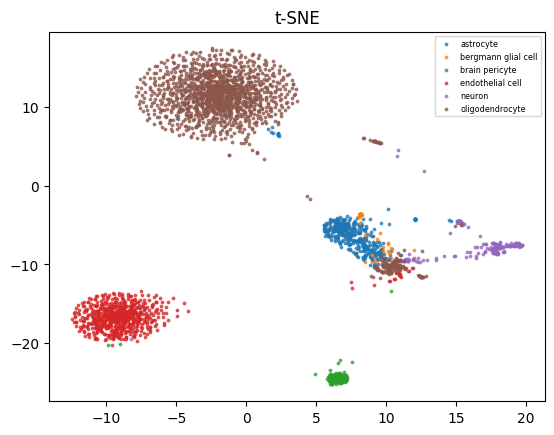

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50)
tsne_X = tsne.fit_transform(logNorm_X)

fig, ax = plt.subplots()           
print("logNorm_X, t-SNE, Silhouette: ", silhouette_score(tsne_X, Y))                    
for i in range(6):
    X1 = tsne_X[Y==i, 0]
    X2 = tsne_X[Y==i, 1]
    ax.scatter(X1, X2, label=list(dic_TypeToID.keys())[i], s=3, alpha=0.7)
ax.legend(loc="best", fontsize='xx-small')
ax.title.set_text('t-SNE')

# UMAP Experiment

logNorm_X, UMAP, Silhouette:  0.5624315


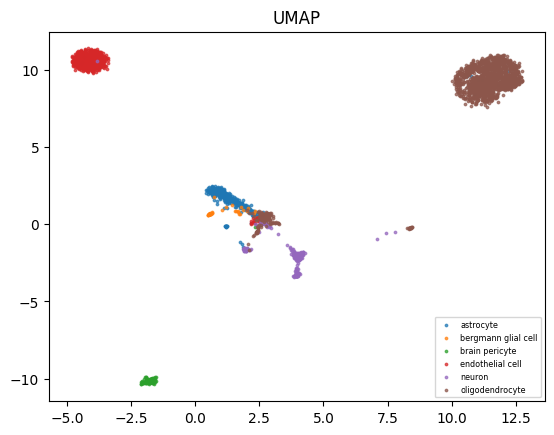

In [20]:
import umap

ump = umap.UMAP(n_components=2)
umap_X = ump.fit_transform(logNorm_X)

fig, ax = plt.subplots()           
print("logNorm_X, UMAP, Silhouette: ", silhouette_score(umap_X, Y))                    
for i in range(6):
    X1 = umap_X[Y==i, 0]
    X2 = umap_X[Y==i, 1]
    ax.scatter(X1, X2, label=list(dic_TypeToID.keys())[i], s=3, alpha=0.7)
ax.legend(loc="best", fontsize='xx-small')
ax.title.set_text('UMAP')